In [108]:
import warnings
warnings.filterwarnings('ignore')

### Импорт библиотек

In [34]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error

In [35]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [36]:
# Импорт библиотеки кластеризации переменных
# https://pypi.org/project/varclushi/
! pip install varclushi
from varclushi import VarClusHi

     |████████████████████████████████| 41 kB 282 kB/s 


## Загрузка данных

In [37]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = '/content/white_wine.csv'

In [85]:
# Загружаем данные из SAS файла
df = pd.read_csv(file_path)
df = df.astype('float')
# Пример данных
df.head()

,fixed acidity,volatile acidity,citric acid,sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target_quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


## Функции обработки

In [86]:
# Метод главных компонент
def pca_transform(X, transform = []):
    pca_model = PCA(n_components='mle')
    pca_model.fit(X)

    if transform == []:
        transform = [X]
    return [pca_model.transform(t) for t in transform]

In [87]:
# Кластеризация переменных
def variable_clustering(X, transform = []):
    var_clust_model = VarClusHi(X, maxeigval2 = .7, maxclus = None)
    var_clust_model.varclus()
    var_clust = var_clust_model.rsquare.loc[:, ["Cluster","Variable","RS_Ratio"]]
    vars = var_clust.sort_values("RS_Ratio").drop_duplicates(['Cluster'],keep='first')["Variable"].to_list()

    if transform == []:
        transform = [X]
    return [t.loc[:, vars] for t in transform]

In [41]:
# Разделение на обучающую, валидационную и тестовую выборку
def data_partition(X, y):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify = y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, stratify = y_test_val, test_size=0.5, random_state=42)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [42]:
# Расчет ошибки прогнозирования
def score_model_mae(model, 
                    X_train, y_train,
                    X_val, y_val,
                    X_test, y_test):
    print(model.__class__.__name__)
    print("TRAIN MSE: {:f}".format(mean_squared_error(y_train, model.predict(X_train))))
    print("VAL MSE: {:f}".format(mean_squared_error(y_val, model.predict(X_val))))
    print("TEST MSE: {:f}".format(mean_squared_error(y_test, model.predict(X_test))))

## Формирование признакового пространства

In [112]:
# Сформируем признаковое пространство:
# Целевая переменная: target_quality. Описывает субъективную оценку качества сорта вина. 
# Остальные переменные - входные. 
# Задача – спрогнозировать оценку эксперта в зависимости от объективных химических показателей вина и выявить важные признаки
y = df["target_quality"].to_frame()
X = df.loc[:, list(set(df.columns) - {"target_quality"})]

# Дискретизация отклика
qtransform = QuantileTransformer(output_distribution='normal', n_quantiles = 5, random_state = 42)
y.values[:] = qtransform.fit_transform(y)

## Часть 1: KNN

In [69]:
from sklearn.neighbors import KNeighborsRegressor

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Стандартизация
scaler = StandardScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# PCA или Variable clustring (вставьте свой код)

# KNN 
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)

# Score
score_model_mae(knn, X_train, y_train, X_val, y_val, X_test, y_test)

KNeighborsRegressor
TRAIN MSE: 0.385404
VAL MSE: 0.441951
TEST MSE: 0.402548


### Вопросы части 1:

1. Какие значения MSE получились на тренировочном, валидационном и тестовом наборе данных?
2. Перед применением KNN вставьте предобработку PCA (Вариант I), Variable clustering (Вариант II). 
3. Сколько переменных теперь передается на вход KNN? Как изменились значения MSE в результате? Почему это могло произойти?

## Часть 2: Regression

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
# Документация для OLS
# https://bookdown.org/mike/data_analysis/ordinary-least-squares.html

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# MinMax стандартизация (вставьте свой код)

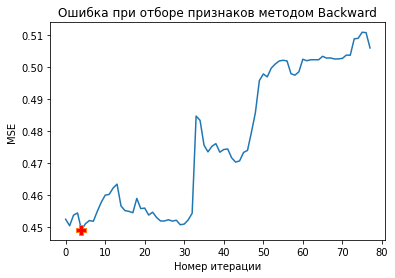

LinearRegression
TRAIN MSE: 0.379855
VAL MSE: 0.449115
TEST MSE: 0.399723


In [73]:
# Построим полиномиальную регрессию (degree = 2)

# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

# Определим лучшее число признаков с помощью Backward (измените код для отбора с помощью Forward)
best_feats = None
features = list(range(X_train.shape[1]))
errs = []
while len(features) > 0:
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
    if min(errs) == err:
        best_feats = features.copy()

    model = sm.OLS(y_train, X_train[:, features])
    res = model.fit()

    # Выбираем худший признак и удаляем из пространства признаков
    worse_feature = features[np.argmax(res.pvalues)]
    features.remove(worse_feature)

# Визуализируем ошибки
idx = len(errs) - len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Backward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)

### Вопросы к части 2:

1. Аналогично алгоритму выбора признаков Backward, опишите алгоритм Forward
2. Какая модель показывает лучшее качество на тестовом наборе? 
3. Какие переменные не вошли в результирующую регрессионую модель? 
4. На каком шаге была выбрана лучшая модель?
5. С помощью summary() определите какая из вошедших переменных наименее важная с точки зрения t-статистики?

5. После разделения данных добавьте MinMaxScaler. Как изменились результаты регрессионной модели с точки числа степеней свободы и значения MSE на тестовом наборе?

## Часть 3: PLS/PCR

In [105]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Метод PCR представляем в виде комбинации PCA с последующей линейной регрессией
pcr = make_pipeline(PCA(n_components=5), LinearRegression())
pcr.fit(X_train, y_train)

pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

# MSE
score_model_mae(pcr, X_train, y_train, X_val, y_val, X_test, y_test)
score_model_mae(pls, X_train, y_train, X_val, y_val, X_test, y_test)

Pipeline
TRAIN MSE: 0.477364
VAL MSE: 0.496493
TEST MSE: 0.471302
PLSRegression
TRAIN MSE: 0.441024
VAL MSE: 0.464150
TEST MSE: 0.445547


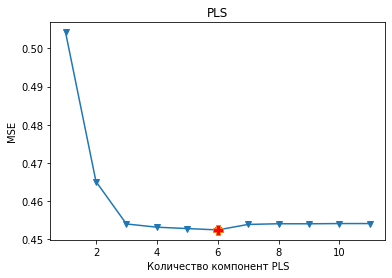

In [106]:
# Необходимо определить лучшее количество компонент

def optimise_comp_cv(X, y, n_comp):
    # Определяем модель (PLS или PCR)
    pls = PLSRegression(n_components=n_comp)

    # Расчет ошибки на кросс-валидации
    y_cv = cross_val_predict(pls, X, y, cv=10)
    mse = mean_squared_error(y, y_cv)
    return mse

# Визуализация MSE
def plot_metrics(vals, ylabel, objective, xticks):
    plt.plot(xticks, np.array(vals), '-v')
    if objective=='min':
        idx = np.argmin(vals)
    else:
        idx = np.argmax(vals)
    plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

    plt.xlabel('Количество компонент PLS')
    plt.xticks = xticks
    plt.ylabel(ylabel)
    plt.title('PLS')
    plt.show()


# Кросс-валидация проводится на обучающей и валидационной выборках
X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
mses = []
list_components = list(range(1, X_tr_val.shape[1]+1))
for n_comp in list_components:
    mse = optimise_comp_cv(X_tr_val, y_tr_val, n_comp)
    mses.append(mse)
plot_metrics(mses, 'MSE', 'min', list_components)

### Вопросы к части 3:

1. Сколько компонент было выбрано для моделей PCR и PLS?
2. Какое значение MSE модели показывают на тестовом наборе?

## Часть 4: LARS + LASSO

In [113]:
# Документация LARS+LASSO
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC

from sklearn.linear_model import LassoLarsIC

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
reg = LassoLarsIC(criterion='aic', normalize=True)
reg.fit(X_tr_val, y_tr_val)

score_model_mae(reg, X_train, y_train, X_val, y_val, X_test, y_test)

LassoLarsIC
TRAIN MSE: 0.440585
VAL MSE: 0.456414
TEST MSE: 0.438269


### Вопросы к части 4:

1. Какое значение MSE модель показывает на тестовом наборе? 
2. Какая пременная была отобрана на первом шаге? 
3. Сколько всего переменных было отобрано?
4. Если бы вместо критерия отбора модели вашего варианта использовался критерий MSE на валидационном наборе, то было бы отобрано больше или меньше переменных?

## Общие вопросы:

1. Зачем при разделении выборкок проводится стратификация по целевой переменной?
2. Какая модель показала лучшее значение MSE на тестовой выборке?